# Improving generalization with regularization
Overfitting on the training data is one of the biggest challenges of machine learning. There are many machine learning algorithms that are able to train on the training data by remembering all cases. In this scenario, the algorithm might not be able to generalize and make a correct prediction on new data. This is an especially big threat for deep learning, where neural networks have large numbers of trainable parameters. Therefore, it is extremely important to create a representative validation set. 
<br><br>
In deep learning, the general advice when tackling new problems is to overfit as much as you can on the training data first. This ensures that your model is able to train on the training data and is complex enough. Afterwards, you should regularize as much as you can to make sure the model is able to generalize on unseen data (the validation set) as well.<br><br>
Most of the techniques used to prevent overfitting can be placed under regularization. Regularization include all techniques in machine learning that explicitly reduce the test (thus generalization) error, sometimes at the expense of a higher training error. Such techniques can be in the form of adding restrictions on the parameter space. This assumes that a model
with small weights is simpler than a model with large weights.<br><br> In the following example, we will apply **L1 regularization** to prevent the model from overfitting.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


### Load data and Feature engineering

In [2]:
data = pd.read_csv('data/hour.csv')
# Feature engineering
ohe_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for feature in ohe_features:
    dummies = pd.get_dummies(data[feature], prefix=feature, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

drop_features = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data = data.drop(drop_features, axis=1)

### Normalize numerical data

In [3]:
norm_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for feature in norm_features:
    mean, std = data[feature].mean(), data[feature].std()
    scaled_features[feature] = [mean, std]
    data.loc[:, feature] = (data[feature] - mean)/std

### Split data for training, validation, and testing

In [4]:
# Save the final month for testing
test_data = data[-31*24:]
data = data[:-31*24]
# Extract the target field
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
# Create a validation set (based on the last )
X_train, y_train = features[:-30*24], targets[:-30*24]
X_val, y_val = features[-30*24:], targets[-30*24:]

### Define the network architecture

In [5]:
model = Sequential()
model.add(Dense(250, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

### Train the network architecture on training data and use the validation set

In [6]:
n_epochs = 4000
batch_size = 1024

history = model.fit(X_train.values, y_train['cnt'], 
                 validation_data=(X_val.values, y_val['cnt']), 
                 batch_size=batch_size, epochs=n_epochs, verbose=0
                )

### Plot training and validation loss

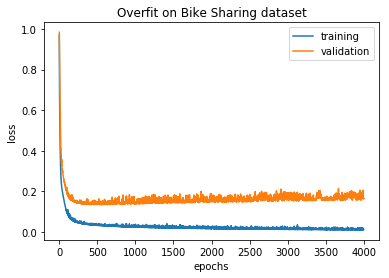

In [7]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='training')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
plt.title('Overfit on Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

Model overfits on training data (training loss shows slightly increasing trend after 1000 epochs)

### We also plot the minimum loss and after how many epochs this minimum has been reached

In [8]:
print('Minimum loss: ', min(history.history['val_loss']), 
      '\nAfter ', np.argmin(history.history['val_loss']), ' epochs')

# Minimum loss:  0.140975862741 
# After  730  epochs

Minimum loss:  0.134414181113 
After  560  epochs


### Define the network architecture with L2 regularization

In [9]:
model_reg = Sequential()
model_reg.add(Dense(250, input_dim=X_train.shape[1], activation='relu',
            kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(150, activation='relu'))
model_reg.add(Dense(50, activation='relu'))
model_reg.add(Dense(25, activation='relu',
            kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(1, activation='linear'))

# Compile model
model_reg.compile(loss='mse', optimizer='sgd', metrics=['mse'])

### Train the adjusted network

In [10]:
history_reg = model_reg.fit(X_train.values, y_train['cnt'], 
validation_data=(X_val.values, y_val['cnt']), 
                 batch_size=batch_size, epochs=n_epochs, verbose=0
                )

### Plot the results

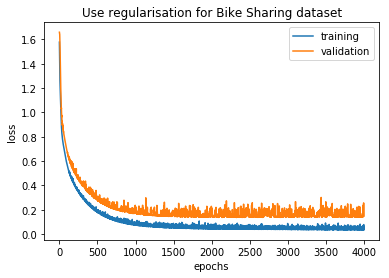

In [11]:
plt.plot(np.arange(len(history_reg.history['loss'])), history_reg.history['loss'], label='training')
plt.plot(np.arange(len(history_reg.history['val_loss'])), history_reg.history['val_loss'], label='validation')
plt.title('Use regularisation for Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

Model with L2 regularization to prevent overfitting

### print the statistics of our model with regularisation 

In [12]:
print('Minimum loss: ', min(history_reg.history['val_loss']), 
      '\nAfter ', np.argmin(history_reg.history['val_loss']), ' epochs')

# Minimum loss:  0.13514482975 
# After  3647  epochs

Minimum loss:  0.136492311954 
After  2325  epochs
